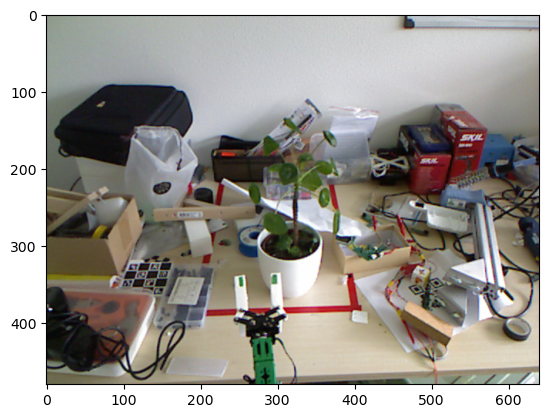

()


NameError: name 'img_with_markers' is not defined

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread('data/rgb/rgb_30.png').astype(np.uint8)
plt.imshow(img)
plt.show()
# Define the dictionary and parameters for detection
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_16h5)
params = cv2.aruco.DetectorParameters()

# Create the detector
detector = cv2.aruco.ArucoDetector(dictionary, params)
marker_corners, marker_ids, _ = detector.detectMarkers(img)


print(marker_corners)
# Draw detected markers on the image
if marker_ids is not None:
    img_with_markers = cv2.aruco.drawDetectedMarkers(img, marker_corners, marker_ids)

# Convert the image from BGR to RGB for displaying with matplotlib
img_rgb = cv2.cvtColor(img_with_markers, cv2.COLOR_BGR2RGB)

# Display the image with detected markers
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [6]:
import time
from module.kinect import Kinect


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
def expand_mask_roi(mask, scale_factor=2):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])  

    new_w, new_h = int(w * scale_factor), int(h * scale_factor)
    mask_region = mask[y:y+h, x:x+w]
    mask_resized = cv2.resize(mask_region, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    new_mask = np.zeros_like(mask)
    new_x, new_y = max(0, x - (new_w - w) // 2), max(0, y - (new_h - h) // 2)
    new_mask[new_y:new_y+new_h, new_x:new_x+new_w] = mask_resized
    return new_mask

def detect_tag_corner(img):
    # Define the dictionary and parameters for detection
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_16h5)
    params = cv2.aruco.DetectorParameters()
    # Create the detector
    detector = cv2.aruco.ArucoDetector(dictionary, params)
    marker_corners, marker_ids, _ = detector.detectMarkers(img)
#     plt.imshow(img)
#     plt.show()
    return marker_corners[0]



def get_incircle(img):
    # Find contours in the mask
    mask_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(mask_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Initialize a distance matrix
    raw_dist = np.empty(mask_gray.shape, dtype=np.float32)
    # Calculate the distance of each point from the contour
    for i in range(mask_gray.shape[0]):
        for j in range(mask_gray.shape[1]):
            raw_dist[i, j] = cv2.pointPolygonTest(contours[0], (j, i), True)
    # Find the maximum distance point
    minVal, maxVal, _, maxDistPt = cv2.minMaxLoc(raw_dist)
    # Get the absolute value of the maximum distance
    maxVal = abs(maxVal)
    # Calculate the radius of the incircle
    radius = int(maxVal)
    # Create an empty mask
    result = np.zeros_like(mask_gray)
    # Draw the filled incircle
    cv2.circle(result, maxDistPt, int(0.8*radius), (255, 255, 255), thickness=-1)
    return result

In [8]:
import glob
def sort_file_by_num(img_list, index=13):
    img_list.sort()
    img_list.sort(key = lambda x: int(x[index:-4])) ##文件名按数字排序
    img_nums=len(img_list)
    for i in range(img_nums):
        img_name=img_list[i]
    
def read_all_files_by_name(filename_pattern, option='rgb'):
    # Get a list of image paths matching the pattern
    img_list = glob.glob(filename_pattern)
    # Read all images and store them in a list
    if option != 'rgb':
        sort_file_by_num(img_list,17)
        images = [cv2.imread(img_path, cv2.IMREAD_UNCHANGED) for img_path in img_list]
    else:
        sort_file_by_num(img_list)
        
        images = [cv2.imread(img_path).astype(np.uint8) for img_path in img_list]
    
    # Filter out any None values that occur if an image fails to load
    images = [img for img in images if img is not None]
    return np.array(images), img_list


### Read Data

In [17]:
rgb_imgs, rgb_img_list = read_all_files_by_name('data/rgb/rgb_*')
depth_imgs, d_img_list = read_all_files_by_name('data/depth/depth_*',option='depth')
ro_c = np.load('data/imitation_arm/nn_train_1000.npy')[:,:3,3]

* check bad data

In [15]:
del_index = []
for index,img in enumerate(rgb_imgs):
    try:
        detect_tag_corner(img)
    except:
#         plt.imshow(img)
#         plt.show()
        del_index.append(index)
rgb_imgs = np.delete(rgb_imgs, (del_index), axis=0)
depth_imgs = np.delete(depth_imgs, (del_index), axis=0)
ro_c = np.delete(ro_c, (del_index), axis=0)

IndexError: index 34 is out of bounds for axis 0 with size 34

In [18]:
rgb_imgs.shape

(70, 480, 640, 3)

In [ ]:
a = [1,1,1,1,1,1,1,1]
np.delete(a,[0,1,2])

In [ ]:
rgb_imgs.shape

### Preprocess Data

In [ ]:
from tqdm import tqdm

camera = Kinect()
X_ori = []
y = []
for i, (rgb_img, d_img) in tqdm(enumerate(zip(rgb_imgs, depth_imgs)), total=len(rgb_imgs), desc="Processing images"):
    corner = detect_tag_corner(rgb_img)
    # Use fillPoly() function and give input as image,
    # end points,color of polygon
    img = np.zeros_like(rgb_img)
    cv2.fillPoly(img, np.int64([corner]), color=(255, 255, 255))
    roi_img = get_incircle(img)
    new_mask = expand_mask_roi(roi_img)
    
    d_img = cv2.bitwise_and(d_img, d_img, mask=new_mask)
    xyz = camera.get_point_xyz(roi_mask=img[:,:,0], rgb_img=rgb_img, depth_img=d_img)
    X_ori.append(xyz)


In [ ]:
import copy
X_ = copy.deepcopy(np.array(X_ori))
y_ = copy.deepcopy(ro_c)
# np.save('X_100',X_)
# np.save('y_100',y_)

In [ ]:
ro_c.shape

In [ ]:
# Identify rows in X with any NaN values
nan_mask = np.isnan(X_).any(axis=1)

In [ ]:
import copy
y = y_[~nan_mask]
X = copy.deepcopy(X_[~nan_mask])


In [ ]:
y = y*1000

### Data Clean

In [ ]:
import copy
y_x = copy.deepcopy(y[:,0])
y_y = copy.deepcopy(y[:,1])
y_z = copy.deepcopy(y[:,2])
X_x = copy.deepcopy(X[:,0])
X_y = copy.deepcopy(X[:,1])
X_z = copy.deepcopy(X[:,2])

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)

In [ ]:
X_x = pca.fit_transform(X,y)

In [ ]:
X_x.shape

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np
clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(X[:,:2])  # fit 10 trees  
clf.set_params(n_estimators=20)  # add 10 more trees  
clf.fit(X[:,:2])  # fit the added trees  

In [ ]:
X.shape

In [ ]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X[:,:2],
    response_method="predict",
    alpha=0.6,
)
scatter = plt.scatter(X[:, 0], X[:, 1], c=y_y, s=20, edgecolor="k")
handles, labels = scatter.legend_elements()
disp.ax_.scatter(X[:, 0], X[:, 1], c=y_y, s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

scatter = plt.scatter(X[:, 0], X[:, 1], c=y_x, s=20, edgecolor="k")
handles, labels = scatter.legend_elements()
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.title("Gaussian inliers with \nuniformly distributed outliers")
plt.show()

In [ ]:
y = y[clf.predict(X[:,:2])==1]
X = X[clf.predict(X[:,:2])==1]


In [ ]:
import copy
y_x = copy.deepcopy(y[:,0])
y_y = copy.deepcopy(y[:,1])
y_z = copy.deepcopy(y[:,2])
X_x = copy.deepcopy(X[:,0])
X_y = copy.deepcopy(X[:,1])
X_z = copy.deepcopy(X[:,2])

In [ ]:
import numpy as np
import sklearn

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
import joblib
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_x,
                                                    random_state=1)

estimators = [  
                ('Ridge', RidgeCV()),
                ('lasso', LassoCV(random_state=42)),
('knr', KNeighborsRegressor(n_neighbors=2))]

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
final_estimator = LinearRegression()
reg_j1 = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator)
reg_j1.fit(X_train,y_train)

In [ ]:
error_y = ((y_test-(reg_j1.predict(X_test)))).astype(np.int16)
plt.hist(error_y,bins=100)

In [ ]:
pca = PCA(n_components=3)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
# modelx
linearmodel = LinearRegression()


In [ ]:
std = StandardScaler().fit(X)
pipe_lx = Pipeline(steps=[("scaler", std), ("pca", pca), ("reg", linearmodel)])



pipe_lx.fit(X_train,y_train)




joblib.dump(pipe_lx, 'weights/lreg.pkl')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
error_y = ((y_test-(pipe_lx.predict(X_test)))).astype(np.int16)
plt.hist(error_y,bins=100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
error_y = ((y_test[:,0]-(pipe_lx.predict(X_test)))).astype(np.int16)
plt.hist(error_y,bins=100)

In [ ]:
error_y = ((y_testx-(linear_modelx.predict(X_testx)))).astype(np.int16)
plt.hist(error_y,bins=100)

In [ ]:
error_y = ((y_testy-(linear_modely.predict(X_testy)))).astype(np.int16)
plt.hist(error_y,bins=100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
error_y = ((y_test-(linear_modely.predict(X_testy)))).astype(np.int16)
plt.hist(error_y,bins=100)

In [ ]:
X_x.shape

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
mlp = MLPRegressor(random_state=42, hidden_layer_sizes=(80,10,4),max_iter=5000,learning_rate='constant',epsilon=0.01)
regr = make_pipeline(StandardScaler(), pca, mlp).fit(X_train, y_train)
regr.score(X_test, y_test)

In [ ]:
error_y = ((y_test-(regr.predict(X_test)))).astype(np.int16)
error_dist = np.linalg.norm(error_y,axis=1)
print(error_dist.shape)
plt.hist(error_dist,bins=50)

In [ ]:
import joblib

# Assuming you have trained a model and stored it in the variable 'model'
# model = YourTrainedModel()

# Save the model to a file
joblib.dump(regr, 'weights/mlp2.pkl')

In [ ]:
pipe_lx = Pipeline(steps=[("scaler", StandardScaler), ("pca", pca), ("reg", linear_modelx)])
pipe_ly = Pipeline(steps=[("scaler", StandardScaler), ("pca", pca), ("reg", linear_modely)])
pipe_lz = Pipeline(steps=[("scaler", StandardScaler), ("pca", pca), ("reg", linear_modelz)])

pipe_lx.predict(X_test)




joblib.dump(pipe_lx, 'weights/ereg_x.pkl')
joblib.dump(pipe_ly, 'weights/ereg_y.pkl')
joblib.dump(pipe_lz, 'weights/ereg_z.pkl')



In [ ]:
import joblib

In [ ]:
xy = regr.predict(np.array([174.98562333,  87.71705945, 713.1147541 ]).reshape(1,-1))/1000

In [ ]:
z =linear_model.predict(np.array([174.98562333,  87.71705945, 713.1147541 ]).reshape(1,-1))/1000

In [ ]:
joblib.dump(linear_model, 'weights/ereg_z.pkl')

In [ ]:
xyz = np.hstack((xy,z.reshape(1,-1)))

In [ ]:
xy.shape

In [ ]:
z.reshape(1,-1)

In [ ]:
xyz

In [ ]:
from sklearn.pipeline import Pipeline
pipe_mlp = Pipeline(steps=[("scaler", StandardScaler), ("pca", pca), ("reg", mlp)])

In [ ]:
pipe_mlp.score(X_test, y_test)

In [ ]:
pipe_mlp = Pipeline(steps=[("scaler", StandardScaler), ("pca", pca), ("reg", mlp)])

### Last-Inch Calibration

In [ ]:
import sys
!pip install -q git+https://github.com/THU-MIG/yolov10.git
!{sys.executable} -m pip install huggingface_hub

In [19]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

In [20]:
model_gripper = YOLOv10('weights/best_gripper.pt')
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 480x640 1 gripper, 840.2ms
Speed: 7.0ms preprocess, 840.2ms inference, 23.6ms postprocess per image at shape (1, 3, 480, 640)


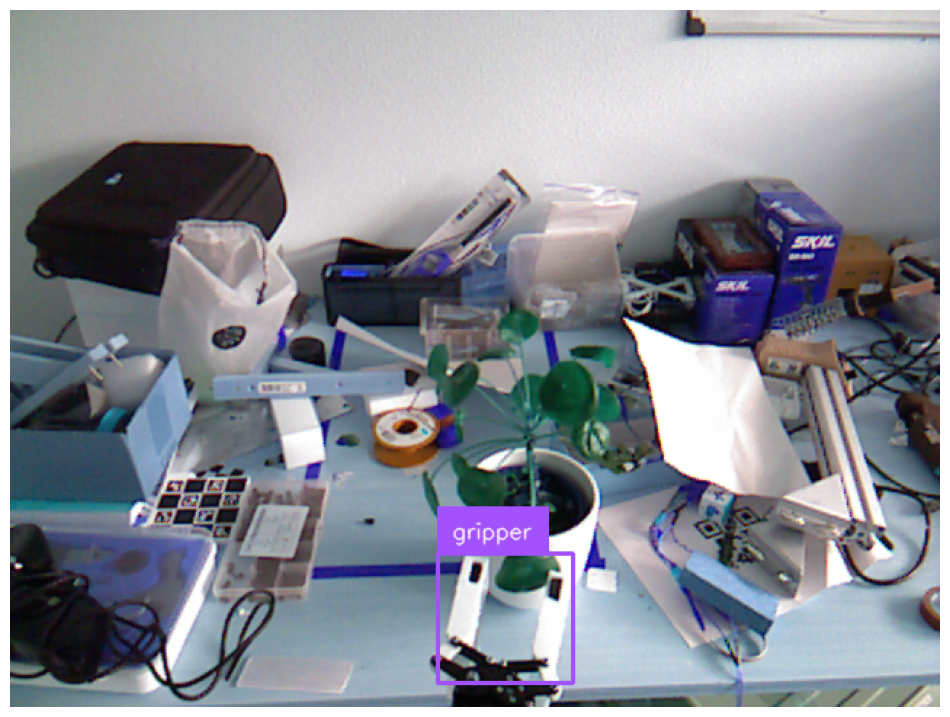

In [21]:
import random
import copy
# Read the image
random_image = cv2.imread('data/rgb/rgb_32.png')

# Convert the image to grayscale
gray_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2GRAY)

# Stack the grayscale image to create a 3-channel image
gray_image = np.stack((gray_image,)*3, axis=-1)
results = model_gripper(source=gray_image, conf=0.5)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=copy.deepcopy(random_image), detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)


In [6]:
def create_mask_from_bbox(image_shape, bbox):
    """
    Create a binary mask from a bounding box.

    Args:
    image_shape (tuple): Shape of the image (height, width).
    bbox (tuple): Bounding box in (x1, y1, x2, y2) format.

    Returns:
    np.array: Binary mask with the bounding box area set to 1.
    """
    # Initialize a blank mask
    mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)

    # Unpack bounding box coordinates
    x1, y1, x2, y2 = bbox[0].astype(np.int32)
    # Set the bounding box area in the mask to 1

    mask[y1-5:y2, x1:x2] = 1

    return mask

In [24]:
mask = create_mask_from_bbox(random_image.shape, detections.xyxy)
gripper = cv2.bitwise_and(random_image,random_image, mask = mask)

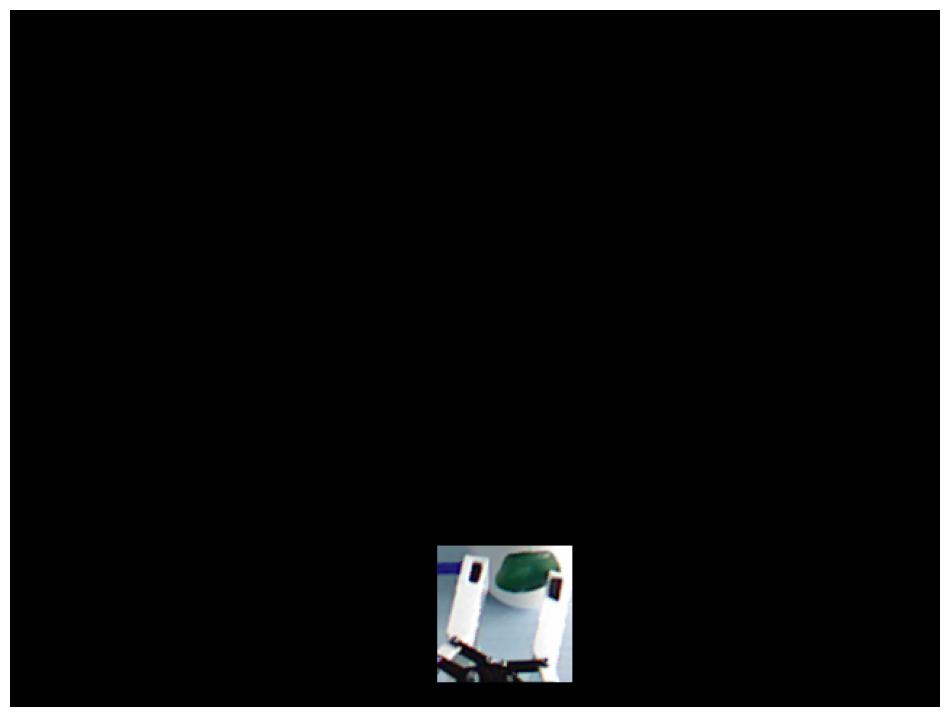

In [25]:
sv.plot_image(gripper)

In [26]:
import supervision as sv
from ultralytics import YOLO
model_leaf = YOLO('weights/best.pt')


0: 480x640 1 leaf, 612.5ms
Speed: 3.9ms preprocess, 612.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


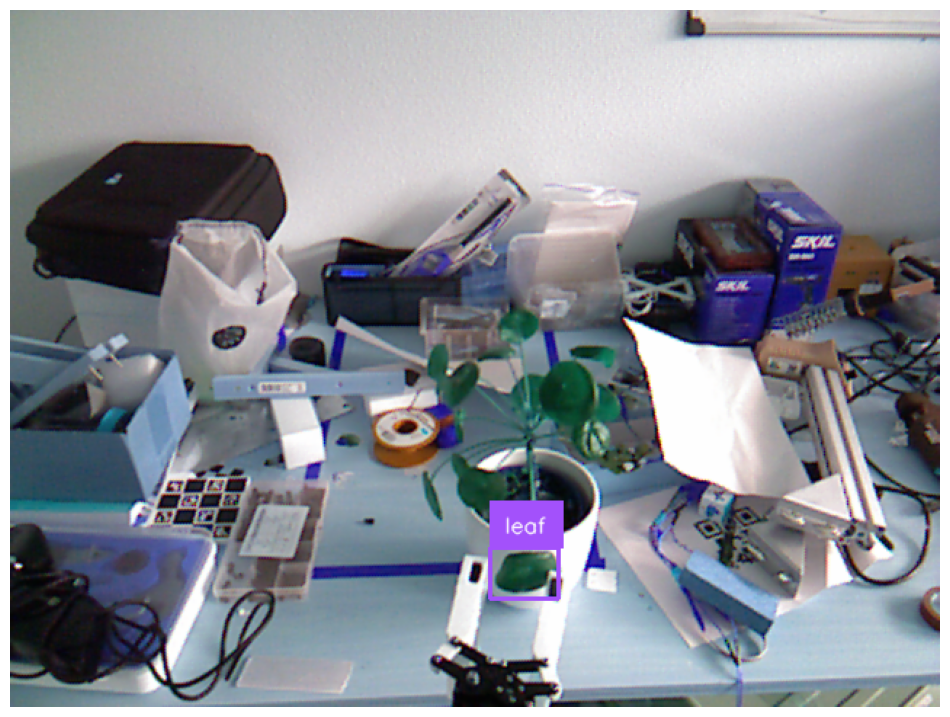

In [27]:
results = model_leaf(source=gripper, conf=0.1)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=copy.deepcopy(random_image), detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)
mask = create_mask_from_bbox(random_image.shape, detections.xyxy)

In [29]:
leaf = cv2.bitwise_and(random_image,random_image, mask = mask)

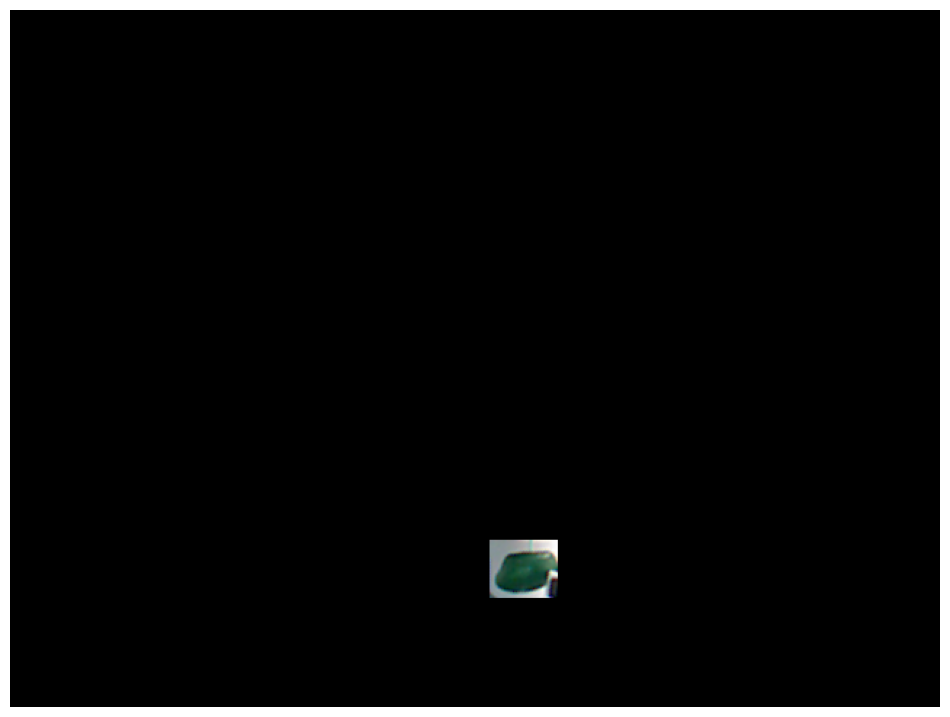

In [30]:
sv.plot_image(leaf)

(-0.5, 639.5, 479.5, -0.5)

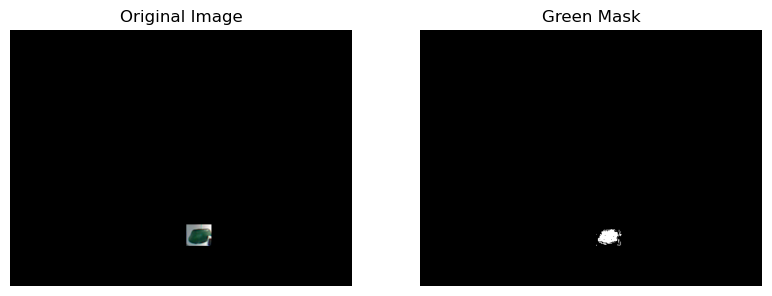

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image from BGR to HSV color space
hsv_image = cv2.cvtColor(leaf, cv2.COLOR_BGR2HSV)

# Define the HSV range for the green color
lower_green = np.array([20, 80, 40])
upper_green = np.array([120, 230, 255])

# Create a mask for the green regions
mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Extract the green regions from the image using the mask
green_regions = cv2.bitwise_and(leaf, leaf, mask=mask)

# Display the original image, the mask, and the green regions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(leaf, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Green Mask')
plt.axis('off')



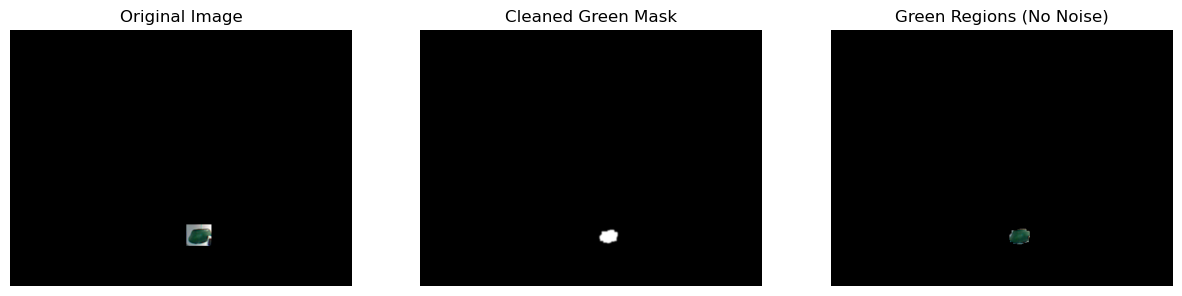

In [32]:
# Apply morphological operations to remove noise
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

# Apply Gaussian blur to smooth the edges
mask_cleaned = cv2.GaussianBlur(mask_cleaned, (5, 5), 0)

# Extract the green regions from the image using the cleaned mask
green_regions = cv2.bitwise_and(leaf, leaf, mask=mask_cleaned)

# Display the original image, the mask, and the green regions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(leaf, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_cleaned, cmap='gray')
plt.title('Cleaned Green Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(green_regions, cv2.COLOR_BGR2RGB))
plt.title('Green Regions (No Noise)')
plt.axis('off')

plt.show()

## Test with new image

In [318]:
img = cv2.imread('data/rgb/rgb_71.png')

x=189, y=327, width=41, height=35

In [283]:
def convert_to_xyxy(x,y,w,h):
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    return x1, y1, x2, y2

def draw_yolo_frame_cv(image, yolo_results):
    results = yolo_results
    x,y,w,h = results
    for i, result in enumerate(results):
        x0, y0, x1, y1 = convert_to_xyxy(x,y,w,h)
        start_point = (int(x0), int(y0))
        end_point = (int(x1), int(y1))
        cv2.rectangle(image, start_point, end_point, color=(255, 0, 0), thickness=2)
        cv2.putText(
            image,
            'leaf',
            (int(x0), int(y0) - 10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.6,
            color=(255, 30, 255),
            thickness=2
        )

    return image

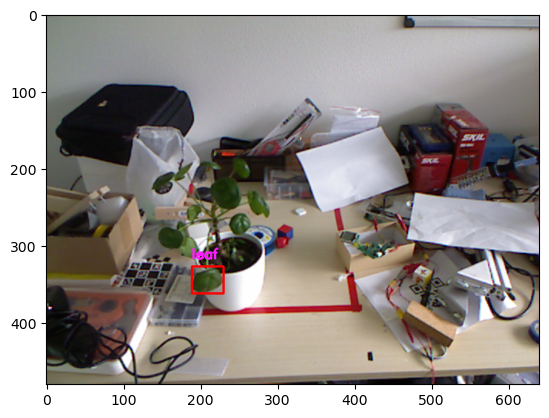

In [285]:
plt.imshow(draw_yolo_frame_cv(img, [189,327,41,35]))

In [319]:
mask = (create_mask_from_bbox(img.shape, np.array([[189, 327, 230, 362]])))
img = cv2.bitwise_and(img, img, mask=mask)

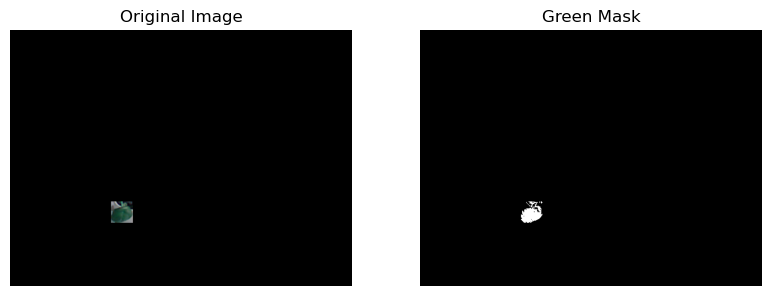

In [352]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image from BGR to HSV color space
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the HSV range for the green color
lower_green = np.array([20, 80, 40])
upper_green = np.array([120, 230, 255])

# Create a mask for the green regions
mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Extract the green regions from the image using the mask
green_regions = cv2.bitwise_and(img, img, mask=mask)

# Display the original image, the mask, and the green regions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Green Mask')
plt.axis('off')


    
    

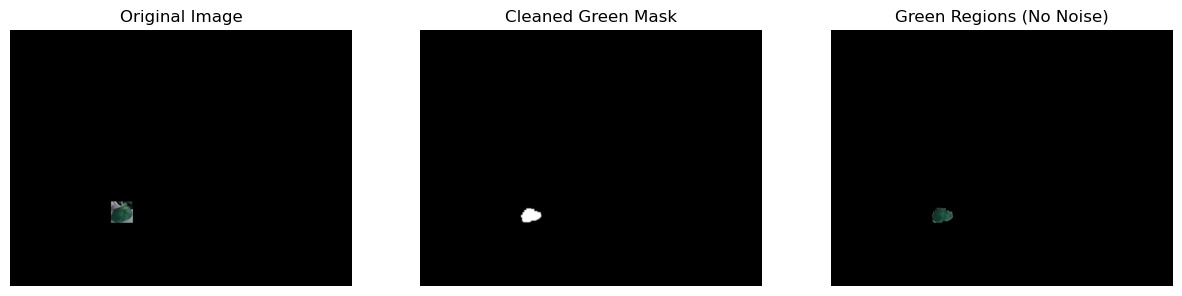

In [345]:
# Apply morphological operations to remove noise
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

# Apply Gaussian blur to smooth the edges
mask_cleaned = cv2.GaussianBlur(mask_cleaned, (3, 3), 0)

# Extract the green regions from the image using the cleaned mask
green_regions = cv2.bitwise_and(img, img, mask=mask_cleaned)

# Display the original image, the mask, and the green regions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_cleaned, cmap='gray')
plt.title('Cleaned Green Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(green_regions, cv2.COLOR_BGR2RGB))
plt.title('Green Regions (No Noise)')
plt.axis('off')

plt.show()

In [313]:
# Convert mask to coordinates
y_coords, x_coords = np.where(mask_cleaned>0.1)
coordinates = list(zip(x_coords, y_coords))

print(f"Number of coordinates: {len(coordinates)}")
print("First 10 coordinates:", coordinates[:10])

Number of coordinates: 966
First 10 coordinates: [(197, 333), (198, 333), (199, 333), (200, 333), (201, 333), (202, 333), (203, 333), (204, 333), (205, 333), (206, 333)]


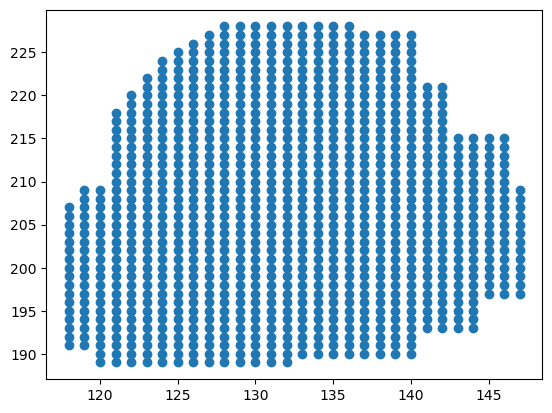

In [339]:
X = 480-y_coords
y = x_coords 
plt.scatter(X, y)

In [340]:
X = np.vstack((X,y)).T

In [88]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
print(pca.components_[0][0]/pca.components_[0][1])

NameError: name 'X' is not defined

In [70]:
# define function
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def segment_leaf_sam(img, yolo_result):
    mask_leaves = sam.predict(img, [yolo_result])
    bbox_xyxy = np.array([convert_to_xyxy(yolo_result)])
    mask = create_mask_from_bbox(img.shape, bbox_xyxy)
    mask = cv2.bitwise_or(mask, mask, mask=mask_leaves)
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

#     Apply Gaussian blur to smooth the edges
    mask_cleaned = cv2.GaussianBlur(mask_cleaned, (3, 3), 0)
    plt.imshow(mask)
    plt.show()
    return mask

def pca_pick_angle(img, yolo_result):
    mask_cleaned = segment_leaf_sam(img, yolo_result)
    # Convert mask to coordinates
#     mask_cleaned = (sam.predict(img, [yolo_result]))

    y_coords, x_coords = np.where(mask_cleaned>0.1)
    coordinates = list(zip(x_coords, y_coords))
    X = 480-y_coords
    y = x_coords 
    X = np.vstack((X,y)).T
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X)
    intcp = pca.components_[0][0]/pca.components_[0][1]
    return intcp

In [89]:
from module.AI_model import Yolo, MobileSAM
import mobile_sam
import cv2
from utils.image_process import convert_to_xyxy
yolo = Yolo()
img = cv2.imread('data/rgb/rgb_01.png')
yolo_result = yolo.predict(img)
# yolo_result = yolo_result[5]
sam = MobileSAM()
# for result in yolo_result:
interc = pca_pick_angle(img, yolo_result[-1])
print(interc)

ValueError: not enough values to unpack (expected 4, got 1)

In [85]:
45*0.768

34.56

segment anything!!!



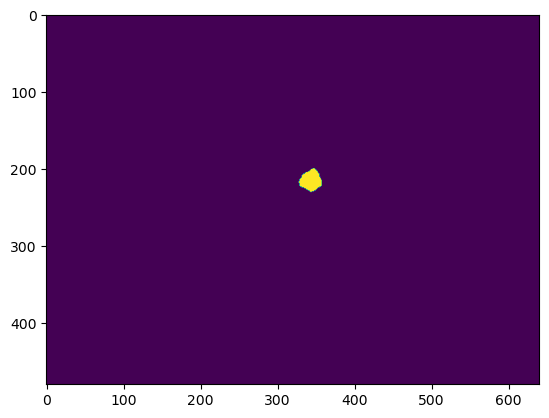

In [47]:
plt.imshow((sam.predict(img, [yolo_result[0]])))

In [12]:
import site
site.getsitepackages()
import sys
sys.path.append(site.getsitepackages()[1])


In [38]:
def bbox2(img):
    # from https://stackoverflow.com/a/31402351/19249364
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

In [39]:
bbox = bbox2(gripper)
cropped = gripper[bbox[0]:bbox[1]+1, bbox[2]:bbox[3]+1, :]
cropped = cv2.resize(cropped,(64,64))
cropped = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
downside = int((bbox[0]+bbox[1])/2)
cropped = gripper[bbox[0]-1:downside+1, bbox[2]:bbox[3]+1, :]

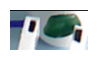

In [40]:
blurred_image = cv2.GaussianBlur(cropped, (3, 3), 0)
sv.plot_image(cropped,size=(1,1))

In [41]:
cropped.shape

(48, 93, 3)

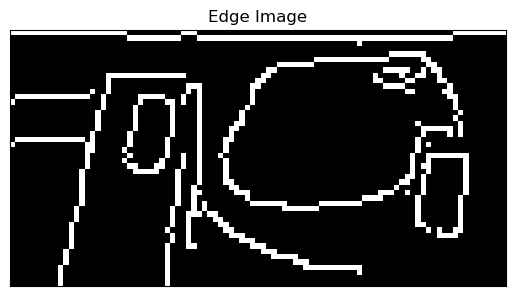

In [42]:
# cropped = blurred_image[:int(cropped.shape[0]/2),:]
cropped = cropped
edges = cv2.Canny(cropped,150,200)
 
# plt.subplot(121),plt.imshow(gripper,cmap = 'gray')
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

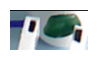

In [43]:
sv.plot_image(cropped,size=(1,1))

In [44]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure

fd, hog_panda = hog(cropped, orientations=8, pixels_per_cell=(4, 4), 
                    cells_per_block=(4, 4), visualize=True,channel_axis=2)



In [45]:
import skimage
skimage.feature

<module 'skimage.feature' from 'D:\\Users\\Hao_Xu\\anaconda3\\lib\\site-packages\\skimage\\feature\\__init__.py'>

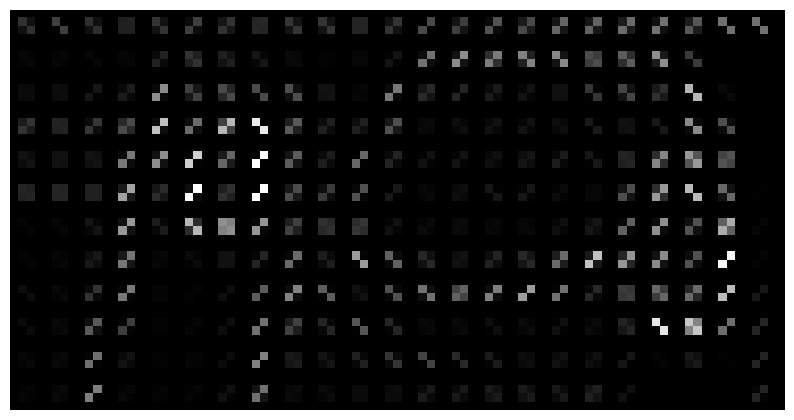

In [46]:
sv.plot_image(hog_panda,size=(10,10))

In [47]:
hog_panda_rescaled = exposure.rescale_intensity(hog_panda, in_range=(50, 100)) 

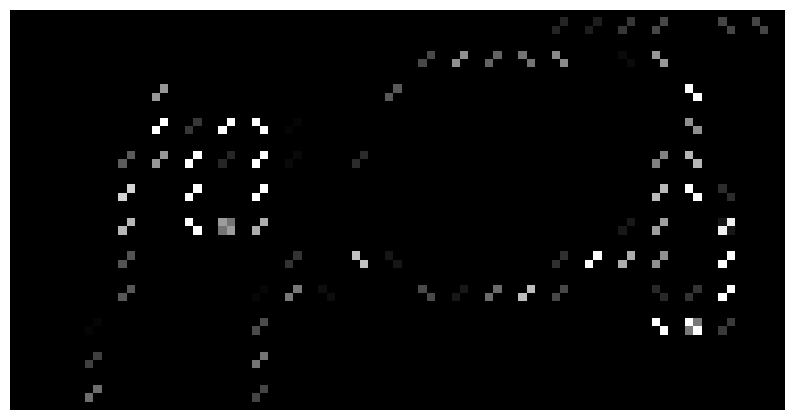

In [48]:
sv.plot_image(hog_panda_rescaled,size=(10,10))

In [243]:
import os
import numpy as np

def load_npy_files(folder_path):
    npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    sort_file_by_num(npy_files,10)
    data_list = []
    
    for npy_file in npy_files:
        file_path = os.path.join(folder_path, npy_file)
        data = np.load(file_path)
        data_list.append(data)
    
    return data_list

# 示例用法
folder_path = 'data/cali/j1/'  # 将此路径替换为包含 .npy 文件的文件夹路径
data_list = load_npy_files(folder_path)

# # 打印加载的数据
# for i, data in enumerate(data_list):
#     print(f"Data from file {i}:")
#     print(data.shape)
y = np.loadtxt('data/cali/j1/cali_j1.txt')

In [244]:
data_list = np.array(data_list)

In [245]:

data_list.shape


(266, 480, 640, 3)

In [246]:
y.shape

(266,)

In [247]:
X = data_list

### Feature Extraction

In [55]:
from tqdm import tqdm
def feat_extract(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.stack((img,)*3, axis=-1)

    results = model_gripper(source=img, conf=0.25,verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    mask = create_mask_from_bbox(img.shape, detections.xyxy)
    gripper = cv2.bitwise_and(img,img, mask = mask)

    bbox = bbox2(gripper)
    downside = int((bbox[0]+bbox[1])/2)+5
    cropped = gripper[bbox[0]-1:downside+1, bbox[2]:bbox[3]+1, :]
#     cropped = gripper[bbox[0]-1:bbox[1]+1, bbox[2]-1:bbox[3]+1, :]
    cropped = cv2.resize(cropped,(64,64))
#     sv.plot_image(cropped,size=[5,5])
    fd, hog_img = hog(cropped[:,:,0], orientations=9, pixels_per_cell=(4, 4), 
        cells_per_block=(4, 4), visualize=True)
#     hog_img = cv2.resize(hog_img,(32,32))
    return hog_img
    

In [175]:
X_canny = []
X_canny_exp = []
for img in tqdm(data_list):
    hog_img = feat_extract(img)
    hog_panda_rescaled = exposure.rescale_intensity(hog_img, in_range=(50, 100)) 
#     sv.plot_image(cropped,size=(1,1))
#     canny = cv2.Canny(cropped,200,500)
#     canny = cv2.resize(canny,(64,64))
#     sv.plot_image(canny,size=(1,1))
#     canny = canny.reshape(1,-1)
#     sv.plot_image(hog_img,size=(1,1))
    X_canny.append(hog_img)
    X_canny_exp.append(hog_panda_rescaled)
X_canny = np.array(X_canny).reshape(len(data_list),-1)
X_canny_exp = np.array(X_canny_exp).reshape(len(data_list),-1)

100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [03:12<00:00,  1.26it/s]


In [57]:
y.shape

(214,)

In [176]:
import numpy as np
import sklearn

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
X_train, X_test, y_train, y_test = train_test_split(X_canny_exp, y,test_size=0.25,
                                                    random_state=1)

In [215]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200,max_depth=11, random_state=4, criterion='log_loss')
clf.fit(X_train, y_train)
y_pred = (clf.predict(X_test))

0.9016393442622951


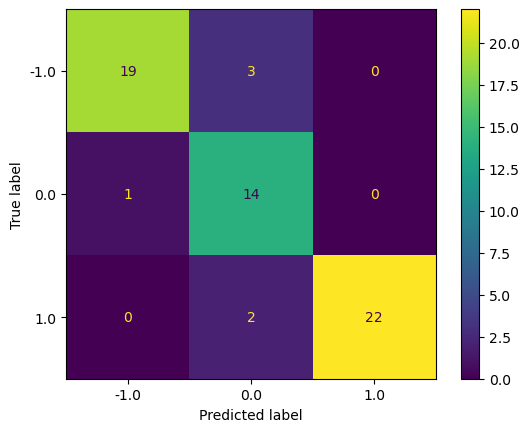

In [216]:
from sklearn.metrics import accuracy_score
y_true = y_test
print(accuracy_score(y_true, y_pred))
# accuracy_score(y_true, y_pred, normalize=False)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [212]:
from sklearn import svm

svm_clf = svm.SVC(C=15)
std_scaler = StandardScaler()
X_canny_exp = std_scaler.fit_transform(X_canny_exp)
X_train, X_test, y_train, y_test = train_test_split(X_canny_exp, y,test_size=0.25,
                                                    random_state=1)
svm_clf.fit(X_train, y_train)

SVC(C=15)

0.819672131147541


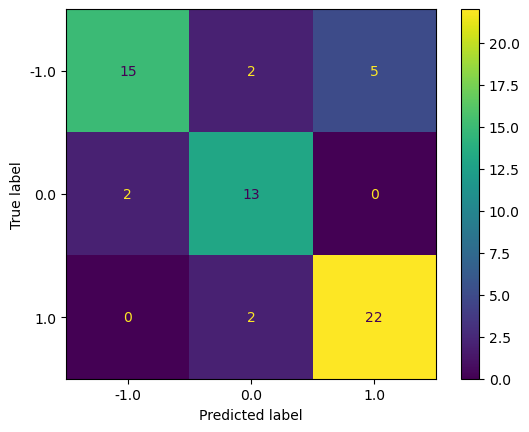

In [213]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (svm_clf.predict(X_test))
y_true = y_test
print(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=svm_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm_clf.classes_)
disp.plot()
plt.show()

In [85]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(32,16,8,), random_state=1, max_iter=1000).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_pred = (clf.predict(X_test))
y_true = y_test
accuracy_score(y_true, y_pred)

0.8148148148148148

In [86]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,y_pred)

array([[19,  4,  0],
       [ 4, 17,  1],
       [ 0,  1,  8]], dtype=int64)

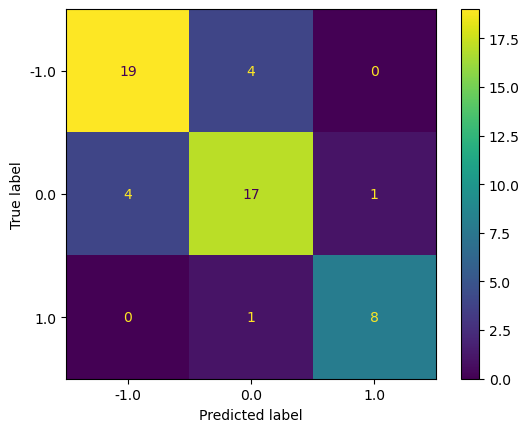

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [66]:
import joblib
joblib.dump(clf, 'weights/mlp_j1.pkl')

['weights/mlp_j1.pkl']

In [88]:
import joblib
joblib.dump(svm_clf, 'weights/svm_j1.pkl')

['weights/svm_j1.pkl']

### End2End Model

In [89]:
import torch
import torch.nn as nn

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.norm1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 8, 5)
        self.norm2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, 6)
        self.norm3 = nn.BatchNorm2d(16)
        self.lin1 = nn.Linear(256, 64)
        self.lin2 = nn.Linear(64, 8)
        self.lin3 = nn.Linear(8, 3)

        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.flatten(x)

        x = self.lin1(x)
        x = self.relu(x)

        x = self.lin2(x)
        x = self.relu(x)
        x = self.lin3(x)
        return x

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.state_dict(), path)



In [249]:
from tqdm import tqdm
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.stack((img,)*3, axis=-1)

    results = model_gripper(source=img, conf=0.1,verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    mask = create_mask_from_bbox(img.shape, detections.xyxy)
    gripper = cv2.bitwise_and(img,img, mask = mask)

    bbox = bbox2(gripper)
    downside = int((bbox[0]+bbox[1])/2)+5
    cropped = gripper[bbox[0]-1:downside+1, bbox[2]:bbox[3]+1, :]
    cropped = cv2.resize(cropped,(64,64))
    return cropped
X = []
for img in tqdm(data_list):
    img = preprocess(img)

#     sv.plot_image(cropped,size=(1,1))
#     canny = cv2.Canny(cropped,200,500)
#     canny = cv2.resize(canny,(64,64))
#     sv.plot_image(canny,size=(1,1))
#     canny = canny.reshape(1,-1)
#     sv.plot_image(hog_img,size=(1,1))
    X.append(img)


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [02:40<00:00,  1.66it/s]


In [250]:
from sklearn.preprocessing import OneHotEncoder



#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# Apply one-hot encoding to the categorical columns
y_hot_encoded = encoder.fit_transform(y.reshape(-1,1))

X = np.array(X)[:,:,:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y_hot_encoded,test_size=0.2,
                                                    random_state=1)

In [251]:
y.shape

(266,)

In [252]:
import torch
import torch.nn as nn

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1,4,5)
        self.norm1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4,8,5)
        self.norm2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8,16,6)
        self.norm3 = nn.BatchNorm2d(16)
        self.lin1  = nn.Linear(256,64)
        self.lin2  = nn.Linear(64,8)
        self.lin3  = nn.Linear(8,3)

        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.1)
        self.relu    = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.maxpool(x)
        x = self.relu(x)


        x = self.flatten(x)


        x = self.lin1(x)
        x = self.relu(x)
       
        x = self.lin2(x)
        x = self.relu(x)
        x = self.lin3(x)
        return x
    
    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.state_dict(), path)

In [253]:
def train_model(X_train, y_train, X_valid, y_valid, path, num_epochs=50, learning_rate=1e-3, lambda_l2=1e-3, batch_size=32):
    
    print("... train model")
    model = Model()
    model.load(PATH)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2 

    X_train_torch = torch.from_numpy(X_train[:,np.newaxis,...])
    y_train_torch = torch.from_numpy(y_train)
    for t in range(num_epochs):
        print("[EPOCH]: %i" % (t), end='\r')
        for i in range(0,len(X_train_torch),batch_size):
            acc = 0
            curr_X = X_train_torch[i:i+batch_size].float()
            curr_Y = y_train_torch[i:i+batch_size].float()
            preds  = model(curr_X)
#             print(torch.argmax(curr_Y, dim=1))
            loss   = criterion(preds, torch.argmax(curr_Y, dim=1))
            print(loss)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.save(path)


In [254]:
train_model(X_train, y_train, X_test, y_test, 'weights/mlp.pth', num_epochs=50, batch_size=16, learning_rate=5e-2)

... train model
tensor(0.6649, grad_fn=<NllLossBackward0>)
tensor(0.4250, grad_fn=<NllLossBackward0>)
tensor(0.8805, grad_fn=<NllLossBackward0>)
tensor(1.5551, grad_fn=<NllLossBackward0>)
tensor(5.0223, grad_fn=<NllLossBackward0>)
tensor(1.6818, grad_fn=<NllLossBackward0>)
tensor(0.9985, grad_fn=<NllLossBackward0>)
tensor(0.1999, grad_fn=<NllLossBackward0>)
tensor(0.3044, grad_fn=<NllLossBackward0>)
tensor(0.0886, grad_fn=<NllLossBackward0>)
tensor(0.3333, grad_fn=<NllLossBackward0>)
tensor(0.3098, grad_fn=<NllLossBackward0>)
tensor(0.5044, grad_fn=<NllLossBackward0>)
tensor(0.5791, grad_fn=<NllLossBackward0>)
tensor(0.5238, grad_fn=<NllLossBackward0>)
tensor(0.1972, grad_fn=<NllLossBackward0>)
tensor(0.2115, grad_fn=<NllLossBackward0>)
tensor(0.4162, grad_fn=<NllLossBackward0>)
tensor(0.5615, grad_fn=<NllLossBackward0>)
tensor(0.2265, grad_fn=<NllLossBackward0>)
tensor(0.3824, grad_fn=<NllLossBackward0>)
tensor(0.2206, grad_fn=<NllLossBackward0>)
tensor(0.2427, grad_fn=<NllLossBackwar

tensor(0.0151, grad_fn=<NllLossBackward0>)
tensor(0.0089, grad_fn=<NllLossBackward0>)
tensor(0.0266, grad_fn=<NllLossBackward0>)
tensor(0.0399, grad_fn=<NllLossBackward0>)
tensor(0.0034, grad_fn=<NllLossBackward0>)
tensor(0.1112, grad_fn=<NllLossBackward0>)
tensor(0.0372, grad_fn=<NllLossBackward0>)
tensor(0.0290, grad_fn=<NllLossBackward0>)
tensor(0.0300, grad_fn=<NllLossBackward0>)
tensor(0.1058, grad_fn=<NllLossBackward0>)
tensor(0.1480, grad_fn=<NllLossBackward0>)
tensor(0.0170, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.3323, grad_fn=<NllLossBackward0>)
tensor(0.0220, grad_fn=<NllLossBackward0>)
tensor(0.0112, grad_fn=<NllLossBackward0>)
tensor(0.0470, grad_fn=<NllLossBackward0>)
tensor(0.0359, grad_fn=<NllLossBackward0>)
tensor(0.0058, grad_fn=<NllLossBackward0>)
tensor(0.1033, grad_fn=<NllLossBackward0>)
tensor(0.0237, grad_fn=<NllLossBackward0>)
tensor(0.0322, grad_fn=<NllLossBackward0>)
tensor(0.0470, grad_fn=<NllLossBackward0>)
tensor(0.07

tensor(0.0218, grad_fn=<NllLossBackward0>)
tensor(0.0014, grad_fn=<NllLossBackward0>)
tensor(0.0176, grad_fn=<NllLossBackward0>)
tensor(0.0048, grad_fn=<NllLossBackward0>)
tensor(0.0053, grad_fn=<NllLossBackward0>)
tensor(0.0169, grad_fn=<NllLossBackward0>)
tensor(0.0919, grad_fn=<NllLossBackward0>)
tensor(0.0881, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.1078, grad_fn=<NllLossBackward0>)
tensor(0.0054, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.0091, grad_fn=<NllLossBackward0>)
tensor(0.0101, grad_fn=<NllLossBackward0>)
tensor(0.0012, grad_fn=<NllLossBackward0>)
tensor(0.0152, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.0035, grad_fn=<NllLossBackward0>)
tensor(0.0063, grad_fn=<NllLossBackward0>)
tensor(0.1239, grad_fn=<NllLossBackward0>)
tensor(0.0982, grad_fn=<NllLossBackward0>)
tensor(0.0042, grad_fn=<NllLossBackward0>)
tensor(0.00

tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0071, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0561, grad_fn=<NllLossBackward0>)
tensor(0.0918, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0754, grad_fn=<NllLossBackward0>)
tensor(0.0020, grad_fn=<NllLossBackward0>)
tensor(0.0019, grad_fn=<NllLossBackward0>)
tensor(0.0052, grad_fn=<NllLossBackward0>)
tensor(0.0030, grad_fn=<NllLossBackward0>)
tensor(0.0007, grad_fn=<NllLossBackward0>)
tensor(0.0056, grad_fn=<NllLossBackward0>)
tensor(0.0023, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0027, grad_fn=<NllLossBackward0>)
tensor(0.0629, grad_fn=<NllLossBackward0>)
tensor(0.0927, grad_fn=<NllLossBackward0>)
tensor(0.0021, grad_fn=<NllLossBackward0>)
tensor(0.0005, grad_fn=<NllLossBackward0>)
tensor(0.06

In [108]:
PATH = 'weights/mlp.pth'

In [255]:
# Model class must be defined somewhere
model = Model()
# model.save(PATH)
model.load(PATH)

# Ensure the loaded model is in evaluation mode
model.eval()

Model(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(6, 6), stride=(1, 1))
  (norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=3, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [256]:
import torch.nn.functional as F

prob = model(torch.from_numpy(X_train[1][np.newaxis,np.newaxis,...]).type(torch.FloatTensor))

In [257]:
model(torch.from_numpy(X_train[0][np.newaxis,np.newaxis,...]).type(torch.FloatTensor))

tensor([[ 6.4868, -0.3364, -5.8271]], grad_fn=<AddmmBackward0>)

In [258]:
# Convert probabilities to predicted class
_, predicted_class = torch.max(prob, 1)
pred_y = predicted_class.data.numpy()
print("Predicted class:", predicted_class)

Predicted class: tensor([0])


In [259]:
# Mapping predicted class index to labels -1, 0, 1
class_mapping = {0: -1, 1: 0, 2: 1}
predicted_label = class_mapping[predicted_class.item()]
print("Predicted label:", predicted_label)

Predicted label: -1


In [260]:
from torch.utils.data import DataLoader, TensorDataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, shuffle=False)

In [261]:
from torch.utils.data import DataLoader, TensorDataset
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Create a TensorDataset and DataLoader
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset,batch_size=1, shuffle=False)

In [262]:
# Ensure no gradient calculations during inference
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0]
        outputs = model(inputs.unsqueeze(0))

        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)

        # Convert probabilities to predicted class
        _, predicted_class = torch.max(probabilities, 1)

        # Map the predicted class index to labels -1, 0, 1
        predicted_labels = [class_mapping[pred.item()] for pred in predicted_class]

        # Append predictions to the list
        all_predictions.extend(predicted_labels)

# Convert the list to a tensor or array if needed
all_predictions = torch.tensor(all_predictions)
print("All predictions:", all_predictions)

All predictions: tensor([-1, -1,  1, -1, -1,  1,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  1, -1,  1, -1, -1,  0, -1,  1, -1,  1,  0,  0, -1,  1,  0, -1, -1, -1, -1,  1, -1, -1,  0,  0,  1,  1,  1,  1,  1, -1,  1,  0,  1,  0,  0, -1,  1,  1])


In [263]:
 batch[0].shape

torch.Size([1, 64, 64])

In [264]:
torch.tensor(X_test[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 64, 64])

In [265]:
model(torch.tensor(X_test[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0))

tensor([[ 6.9883, -1.0948, -5.8728]], grad_fn=<AddmmBackward0>)

In [266]:
model

Model(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(6, 6), stride=(1, 1))
  (norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=3, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

0.9259259259259259

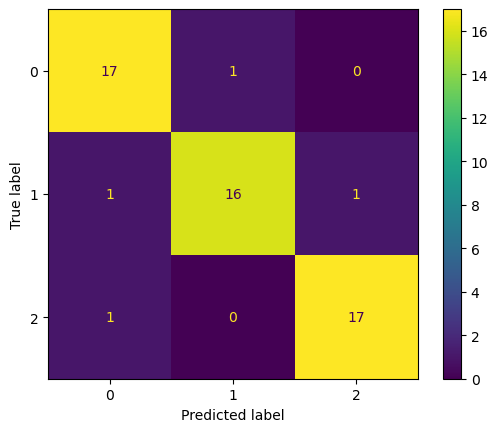

In [267]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(encoder.inverse_transform(y_test), all_predictions)
ConfusionMatrixDisplay(cm).plot()
accuracy_score(encoder.inverse_transform(y_test), all_predictions)

In [ ]:
import joblib
joblib.dump(encoder, 'encoder.joblib') # save the model
encoder = joblib.load('encoder.joblib') # load and reuse the model

In [ ]:
(y_test)

In [ ]:
!conda env list


In [ ]:
import sklearn